# Deep Learning with Keras

*Authors: Evan Carey*

*Copyright 2019, BH Analytics, LLC*

## Overview

In this workbook, we will continue our prior in class work on exploring keras with tensorflow and fitting a feed-forward artificial neural network.  We will fit increasingly complex functions of a continuous outcome using the keras interface to tensorflow. 

## Libraries

In [1]:
import os
import pathlib
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
## Enable inline plotting for graphics
%matplotlib inline
## Set default figure size to be larger 
## this may only work in matplotlib 2.0+!
matplotlib.rcParams['figure.figsize'] = [10.0,6.0]
## Enable multiple outputs from jupyter cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
## Get Version information
print(sys.version)
print("Pandas version: {0}".format(pd.__version__))
print("Matplotlib version: {0}".format(matplotlib.__version__))
print("Numpy version: {0}".format(np.__version__))
print("Tensorflow version: {0}".format(tf.__version__))

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Pandas version: 0.24.2
Matplotlib version: 3.0.3
Numpy version: 1.16.2
Tensorflow version: 1.13.1


## Implementing a simple linear regression in a deep learning framework

Let's simulate some basic data, then implement a linear relationship with noise as a test case to estimate the weights from the data. We will then expand this to non-linear relationships. 

In [5]:
## simulate linear model
np.random.seed(12)
n = 500
x1 = np.random.normal(loc=100,
                      scale=10,
                      size=n)
## simulate outcome
error_1 = \
    np.random.normal(loc=0,
                     scale=80,
                     size=n)
## map to outcome
y1 = 4 + 33*x1 + error_1

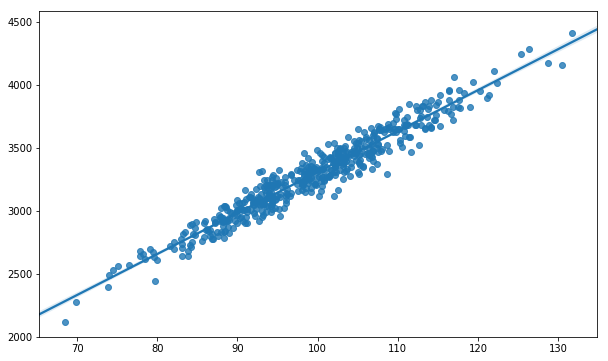

In [6]:
## plot relationship
sns.regplot(x1,y1)

Here we use the sequential model API in Keras to specify a simply feed-forward network. This only has one layer with one unit, thus it is identical to a simple linear model. We expect to recover the model using this approach.

Note we are using the keras module here. Tensorflow also has it's own keras namespace, `tensorflow.keras`,which can be confusing. The code would look very similar if we used `tensorflow.keras` instead of just `keras`. 

We write a function that returns a sequential model with a single layer with a linear activation function. We specify stochastic gradient descent as the optimizer. We add in a metric of mean absolute error, which means that metric (in addition to the mean squared error) will be calcualted for each epoch. 

In [7]:
from keras import models
from keras import layers
from keras import optimizers
## build the model using a function since we will call it multiple times
def build_model1():
    model = models.Sequential()
    model.add(layers.Dense(1,
                           activation = 'linear',
                           input_dim=1))
    model.compile(optimizer ='SGD', 
                  loss = 'mse',
                  metrics = ['mae'])
    return model

Using TensorFlow backend.


In [8]:
## scale data with a transformer so we can later apply the same transformation
from sklearn import preprocessing
trans_1 = preprocessing.StandardScaler().fit(x1.reshape(-1, 1))
x1_scale = trans_1.transform(x1.reshape(-1, 1)) ## reshape since sklearn wants a 2d object here

## fit this model/architecture to my data
regr = build_model1()
regr.fit(x1_scale,
         y1,
         epochs = 20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 0s 235us/step - loss: 8260251.1720 - mean_absolute_error: 2846.7355
Epoch 2/20
500/500 [==============================] - 0s 18us/step - loss: 4324709.7580 - mean_absolute_error: 2059.5990
Epoch 3/20
500/500 [==============================] - 0s 14us/step - loss: 2267597.4400 - mean_absolute_error: 1490.0549
Epoch 4/20
500/500 [==============================] - 0s 16us/step - loss: 1191319.5835 - mean_absolute_error: 1078.7248
Epoch 5/20
500/500 [==============================] - 0s 14us/step - loss: 627457.6795 - mean_absolute_error: 780.5336
Epoch 6/20
500/500 [==============================] - 0s 16us/step - loss: 332252.3488 - mean_absolute_error: 565.2685
Epoch 7/20
500/500 [==============================] - 0s 16us/step - loss: 177479.3299 - mean_absolute_error: 408.7427
Epoch 8/20
500/500 [==================

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [9]:
## summarize model
regr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [10]:
## Retrieve the weights
regr.get_weights()

[array([[326.64847]], dtype=float32), array([3280.691], dtype=float32)]

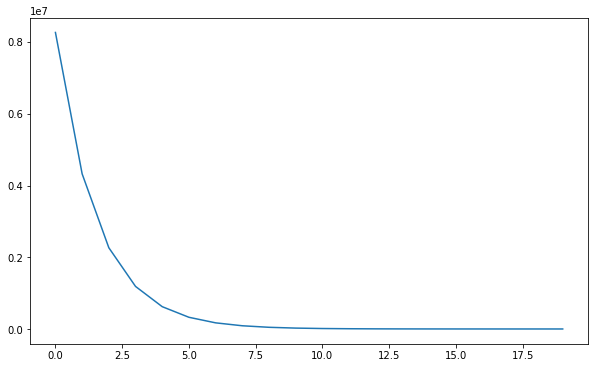

In [11]:
## plot the loss function per epoch
plt.plot(regr.history.history['loss'])

['loss', 'mean_absolute_error']

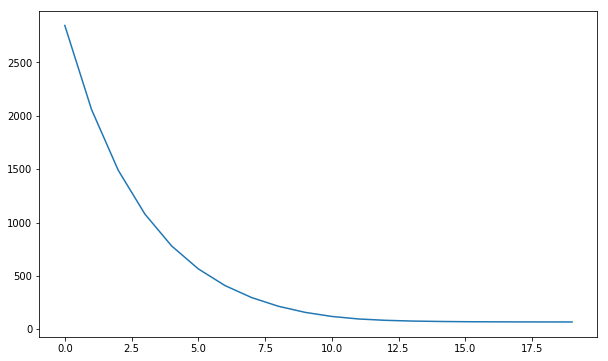

In [12]:
## plot a metric per epoch
regr.metrics_names
plt.plot(regr.history.history['mean_absolute_error'])

It looks like the model fit well by the 6th or 7th epich then did not improve further. 

We can also understand how well the model fits by plotting the predictions against the original data:

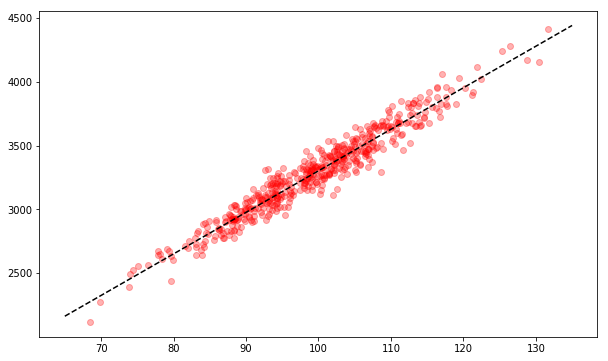

In [13]:
## plot data and predictions
## original data
plt.plot(x1, y1,'ro',alpha=0.3)
## generate regular points along the range of x 
x1_range = np.linspace(65,135,200)
## make predictions and plot
plt.plot(x1_range, 
         regr.predict(trans_1.transform(x1_range.reshape(-1, 1))),
         'k--')

As expected, the model fit a single line of best fit to the data.

## More complex polynomial model

Now let's make the data a bit more complex. I will simulate a polynomial relationship which we can then visualize:

In [14]:
## simulate polynomial model
np.random.seed(12)
import scipy.stats as ss
n = 500
x2 = np.random.normal(loc=0,
                      scale=4,
                      size=n)
## simulate outcome
error_2 = \
    np.random.normal(loc=0,
                     scale=100,
                     size=n)
## map to outcome
y2 = (x2+3)*(x2-2)**2 + error_2

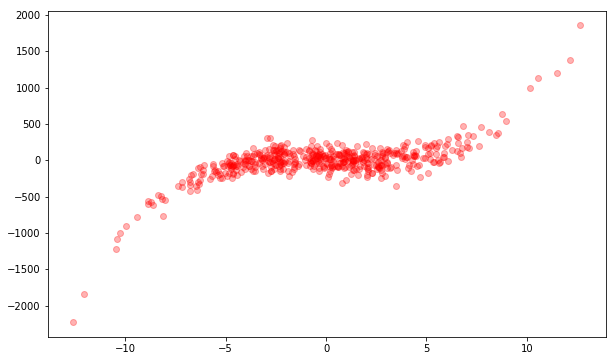

In [15]:
## plot this function
plt.plot(x2, y2,'ro',alpha=0.3)

If we use the same model as before, it should only fit a linear line of best fit (an underfit). Let's give it a try:

In [16]:
## scale data with a transformer so we can later apply the same transformation
from sklearn import preprocessing
trans_2 = preprocessing.StandardScaler().fit(x2.reshape(-1, 1))
x2_scale = trans_2.transform(x2.reshape(-1, 1)) ## reshape since sklearn wants a 2d object here

## fit this model/architecture to my data
regr2 = build_model1()
regr2.fit(x2_scale,
          y2,
          epochs = 20)

Epoch 1/20
500/500 [==============================] - 0s 218us/step - loss: 63452.8422 - mean_absolute_error: 137.1972
Epoch 2/20
500/500 [==============================] - 0s 31us/step - loss: 53637.7436 - mean_absolute_error: 128.5580
Epoch 3/20
500/500 [==============================] - 0s 0us/step - loss: 48460.8325 - mean_absolute_error: 126.2241
Epoch 4/20
500/500 [==============================] - 0s 41us/step - loss: 45750.0994 - mean_absolute_error: 126.9349
Epoch 5/20
500/500 [==============================] - 0s 18us/step - loss: 44141.1432 - mean_absolute_error: 128.5070
Epoch 6/20
500/500 [==============================] - 0s 16us/step - loss: 43345.3239 - mean_absolute_error: 129.7567
Epoch 7/20
500/500 [==============================] - 0s 14us/step - loss: 42857.1527 - mean_absolute_error: 130.7565
Epoch 8/20
500/500 [==============================] - 0s 16us/step - loss: 42560.9163 - mean_absolute_error: 132.1128
Epoch 9/20
500/500 [==============================] - 0s

Now let's check out how the model converged by visualizing the loss function and MAE:

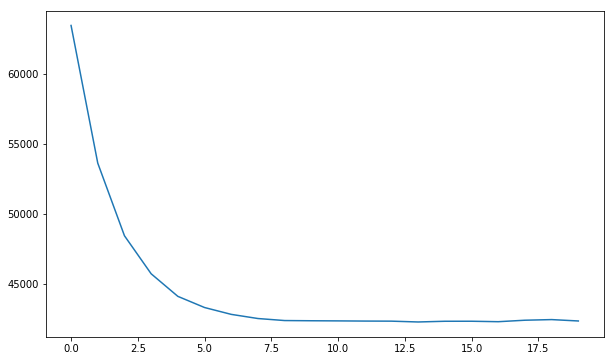

In [17]:
## plot the loss function per epoch
plt.plot(regr2.history.history['loss'])

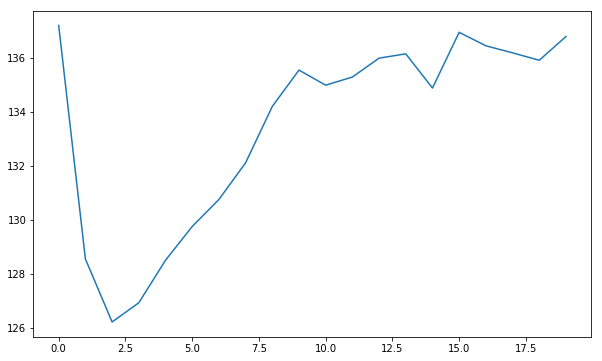

In [18]:
## plot the loss function per epoch
plt.plot(regr2.history.history['mean_absolute_error'])

The loss functions converged as expected, but the other metric (the MAE) is all over the place! What happened? Let's check the predictions to better understand:

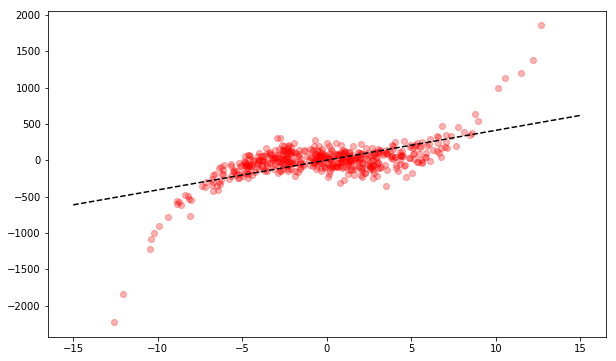

In [19]:
## original data
plt.plot(x2, y2,'ro',alpha=0.3)
## generate regular points along the range of x 
x2_range = np.linspace(-15,15,200)
## make predictions and plot
plt.plot(x2_range, 
         regr2.predict(trans_2.transform(x2_range.reshape(-1, 1))),
         'k--')

As expected, the straight line of fit is not a good model here! We need to make the neural network a bit more complex (deeper or wider). Let's specify a new model architecture where there is a single hidden layer with 64 units, then retrain the model. 

In [20]:
## build the model using a function since we would potentially call it multiple times
## add a single hidden dense layer with 64 units
def build_model2():
    model = models.Sequential()
    model.add(layers.Dense(64,
                           activation = 'relu',
                           input_dim=1))
    model.add(layers.Dense(1,
                           activation = 'linear'))
    model.compile(optimizer ='RMSprop', ## use RMSProp here as SGD fails to converge
                  loss = 'mse',
                  metrics = ['mae'])
    return model

In [21]:
## fit this model/architecture to my data
regr3 = build_model2()
regr3.fit(x2_scale,
         y2,
         epochs = 1500,
         batch_size = 64,
         verbose=1)

Epoch 1/1500
500/500 [==============================] - 0s 343us/step - loss: 69938.6078 - mean_absolute_error: 144.5819
Epoch 2/1500
500/500 [==============================] - 0s 0us/step - loss: 69900.2230 - mean_absolute_error: 144.5337
Epoch 3/1500
500/500 [==============================] - 0s 0us/step - loss: 69871.1823 - mean_absolute_error: 144.4961
Epoch 4/1500
500/500 [==============================] - 0s 37us/step - loss: 69843.0415 - mean_absolute_error: 144.4621
Epoch 5/1500
500/500 [==============================] - 0s 12us/step - loss: 69815.6482 - mean_absolute_error: 144.4238
Epoch 6/1500
500/500 [==============================] - 0s 12us/step - loss: 69789.4170 - mean_absolute_error: 144.3958
Epoch 7/1500
500/500 [==============================] - 0s 10us/step - loss: 69763.1337 - mean_absolute_error: 144.3597
Epoch 8/1500
500/500 [==============================] - 0s 10us/step - loss: 69737.3379 - mean_absolute_error: 144.3290
Epoch 9/1500
500/500 [===================

500/500 [==============================] - 0s 10us/step - loss: 61049.1257 - mean_absolute_error: 134.2155
Epoch 136/1500
500/500 [==============================] - 0s 10us/step - loss: 60957.7875 - mean_absolute_error: 134.1184
Epoch 137/1500
500/500 [==============================] - 0s 10us/step - loss: 60864.4107 - mean_absolute_error: 134.0303
Epoch 138/1500
500/500 [==============================] - 0s 8us/step - loss: 60767.3448 - mean_absolute_error: 133.9335
Epoch 139/1500
500/500 [==============================] - 0s 8us/step - loss: 60673.9104 - mean_absolute_error: 133.8459
Epoch 140/1500
500/500 [==============================] - 0s 10us/step - loss: 60585.3050 - mean_absolute_error: 133.7512
Epoch 141/1500
500/500 [==============================] - 0s 10us/step - loss: 60491.6233 - mean_absolute_error: 133.6542
Epoch 142/1500
500/500 [==============================] - 0s 12us/step - loss: 60393.0494 - mean_absolute_error: 133.5596
Epoch 143/1500
500/500 [=================

500/500 [==============================] - 0s 10us/step - loss: 51093.3436 - mean_absolute_error: 130.9068
Epoch 269/1500
500/500 [==============================] - 0s 10us/step - loss: 51046.8477 - mean_absolute_error: 130.9316
Epoch 270/1500
500/500 [==============================] - 0s 8us/step - loss: 50997.4134 - mean_absolute_error: 130.9717
Epoch 271/1500
500/500 [==============================] - 0s 10us/step - loss: 50959.6332 - mean_absolute_error: 130.9746
Epoch 272/1500
500/500 [==============================] - 0s 10us/step - loss: 50912.8890 - mean_absolute_error: 131.0137
Epoch 273/1500
500/500 [==============================] - 0s 10us/step - loss: 50876.1901 - mean_absolute_error: 131.0404
Epoch 274/1500
500/500 [==============================] - 0s 10us/step - loss: 50836.3028 - mean_absolute_error: 131.0749
Epoch 275/1500
500/500 [==============================] - 0s 8us/step - loss: 50799.6369 - mean_absolute_error: 131.0962
Epoch 276/1500
500/500 [=================

500/500 [==============================] - 0s 10us/step - loss: 47625.7408 - mean_absolute_error: 133.6353
Epoch 403/1500
500/500 [==============================] - 0s 10us/step - loss: 47610.3089 - mean_absolute_error: 133.5935
Epoch 404/1500
500/500 [==============================] - 0s 8us/step - loss: 47591.4134 - mean_absolute_error: 133.6154
Epoch 405/1500
500/500 [==============================] - 0s 12us/step - loss: 47580.0512 - mean_absolute_error: 133.6047
Epoch 406/1500
500/500 [==============================] - 0s 10us/step - loss: 47565.6933 - mean_absolute_error: 133.6433
Epoch 407/1500
500/500 [==============================] - 0s 8us/step - loss: 47550.7946 - mean_absolute_error: 133.6676
Epoch 408/1500
500/500 [==============================] - 0s 10us/step - loss: 47537.0780 - mean_absolute_error: 133.6458
Epoch 409/1500
500/500 [==============================] - 0s 8us/step - loss: 47523.4096 - mean_absolute_error: 133.6531
Epoch 410/1500
500/500 [==================

500/500 [==============================] - 0s 10us/step - loss: 46272.8393 - mean_absolute_error: 134.5599
Epoch 537/1500
500/500 [==============================] - 0s 10us/step - loss: 46263.1414 - mean_absolute_error: 134.5058
Epoch 538/1500
500/500 [==============================] - 0s 10us/step - loss: 46258.8090 - mean_absolute_error: 134.5295
Epoch 539/1500
500/500 [==============================] - 0s 16us/step - loss: 46250.6111 - mean_absolute_error: 134.5339
Epoch 540/1500
500/500 [==============================] - 0s 12us/step - loss: 46241.4309 - mean_absolute_error: 134.5296
Epoch 541/1500
500/500 [==============================] - 0s 12us/step - loss: 46231.2845 - mean_absolute_error: 134.5582
Epoch 542/1500
500/500 [==============================] - 0s 10us/step - loss: 46224.3342 - mean_absolute_error: 134.5744
Epoch 543/1500
500/500 [==============================] - 0s 10us/step - loss: 46221.1864 - mean_absolute_error: 134.5222
Epoch 544/1500
500/500 [===============

500/500 [==============================] - 0s 10us/step - loss: 45306.5373 - mean_absolute_error: 134.3823
Epoch 671/1500
500/500 [==============================] - 0s 10us/step - loss: 45295.6120 - mean_absolute_error: 134.3223
Epoch 672/1500
500/500 [==============================] - 0s 10us/step - loss: 45292.7762 - mean_absolute_error: 134.3281
Epoch 673/1500
500/500 [==============================] - 0s 8us/step - loss: 45282.3896 - mean_absolute_error: 134.3063
Epoch 674/1500
500/500 [==============================] - 0s 8us/step - loss: 45269.7115 - mean_absolute_error: 134.2953
Epoch 675/1500
500/500 [==============================] - 0s 12us/step - loss: 45264.7583 - mean_absolute_error: 134.3442
Epoch 676/1500
500/500 [==============================] - 0s 10us/step - loss: 45261.6557 - mean_absolute_error: 134.2984
Epoch 677/1500
500/500 [==============================] - 0s 8us/step - loss: 45249.1457 - mean_absolute_error: 134.2807
Epoch 678/1500
500/500 [==================

500/500 [==============================] - 0s 10us/step - loss: 44215.6283 - mean_absolute_error: 133.1302
Epoch 805/1500
500/500 [==============================] - 0s 10us/step - loss: 44212.4629 - mean_absolute_error: 133.1128
Epoch 806/1500
500/500 [==============================] - 0s 10us/step - loss: 44207.6229 - mean_absolute_error: 133.1994
Epoch 807/1500
500/500 [==============================] - 0s 10us/step - loss: 44198.8715 - mean_absolute_error: 133.1101
Epoch 808/1500
500/500 [==============================] - 0s 10us/step - loss: 44189.8305 - mean_absolute_error: 133.0952
Epoch 809/1500
500/500 [==============================] - 0s 10us/step - loss: 44182.6769 - mean_absolute_error: 133.0763
Epoch 810/1500
500/500 [==============================] - 0s 10us/step - loss: 44174.9507 - mean_absolute_error: 133.0709
Epoch 811/1500
500/500 [==============================] - 0s 12us/step - loss: 44162.7553 - mean_absolute_error: 133.0825
Epoch 812/1500
500/500 [===============

500/500 [==============================] - 0s 10us/step - loss: 43333.4793 - mean_absolute_error: 133.2490
Epoch 939/1500
500/500 [==============================] - 0s 12us/step - loss: 43322.5988 - mean_absolute_error: 133.3048
Epoch 940/1500
500/500 [==============================] - 0s 10us/step - loss: 43327.8190 - mean_absolute_error: 133.2335
Epoch 941/1500
500/500 [==============================] - 0s 10us/step - loss: 43315.5516 - mean_absolute_error: 133.2532
Epoch 942/1500
500/500 [==============================] - 0s 10us/step - loss: 43312.4411 - mean_absolute_error: 133.2922
Epoch 943/1500
500/500 [==============================] - 0s 10us/step - loss: 43307.5471 - mean_absolute_error: 133.3012
Epoch 944/1500
500/500 [==============================] - 0s 10us/step - loss: 43297.1128 - mean_absolute_error: 133.2802
Epoch 945/1500
500/500 [==============================] - 0s 10us/step - loss: 43294.8241 - mean_absolute_error: 133.3148
Epoch 946/1500
500/500 [===============

500/500 [==============================] - 0s 8us/step - loss: 42750.7887 - mean_absolute_error: 133.5633
Epoch 1072/1500
500/500 [==============================] - 0s 10us/step - loss: 42748.6502 - mean_absolute_error: 133.5762
Epoch 1073/1500
500/500 [==============================] - 0s 8us/step - loss: 42737.3356 - mean_absolute_error: 133.5602
Epoch 1074/1500
500/500 [==============================] - 0s 10us/step - loss: 42744.8954 - mean_absolute_error: 133.6076
Epoch 1075/1500
500/500 [==============================] - 0s 10us/step - loss: 42738.1871 - mean_absolute_error: 133.5186
Epoch 1076/1500
500/500 [==============================] - 0s 10us/step - loss: 42727.3985 - mean_absolute_error: 133.5567
Epoch 1077/1500
500/500 [==============================] - 0s 10us/step - loss: 42733.2592 - mean_absolute_error: 133.6025
Epoch 1078/1500
500/500 [==============================] - 0s 10us/step - loss: 42729.5939 - mean_absolute_error: 133.5591
Epoch 1079/1500
500/500 [=========

500/500 [==============================] - 0s 10us/step - loss: 42390.1839 - mean_absolute_error: 134.0563
Epoch 1204/1500
500/500 [==============================] - 0s 10us/step - loss: 42384.3458 - mean_absolute_error: 134.0562
Epoch 1205/1500
500/500 [==============================] - 0s 10us/step - loss: 42389.8396 - mean_absolute_error: 134.1013
Epoch 1206/1500
500/500 [==============================] - 0s 10us/step - loss: 42390.7172 - mean_absolute_error: 134.0232
Epoch 1207/1500
500/500 [==============================] - 0s 10us/step - loss: 42384.6628 - mean_absolute_error: 134.0901
Epoch 1208/1500
500/500 [==============================] - 0s 10us/step - loss: 42384.4439 - mean_absolute_error: 133.9964
Epoch 1209/1500
500/500 [==============================] - 0s 10us/step - loss: 42376.5595 - mean_absolute_error: 134.0970
Epoch 1210/1500
500/500 [==============================] - 0s 8us/step - loss: 42376.1208 - mean_absolute_error: 134.0244
Epoch 1211/1500
500/500 [========

500/500 [==============================] - 0s 10us/step - loss: 42270.1372 - mean_absolute_error: 134.9650
Epoch 1336/1500
500/500 [==============================] - 0s 10us/step - loss: 42265.0064 - mean_absolute_error: 134.9882
Epoch 1337/1500
500/500 [==============================] - 0s 10us/step - loss: 42276.5236 - mean_absolute_error: 134.9179
Epoch 1338/1500
500/500 [==============================] - 0s 10us/step - loss: 42259.4089 - mean_absolute_error: 135.0254
Epoch 1339/1500
500/500 [==============================] - 0s 10us/step - loss: 42259.9659 - mean_absolute_error: 134.9684
Epoch 1340/1500
500/500 [==============================] - 0s 10us/step - loss: 42261.5348 - mean_absolute_error: 134.9817
Epoch 1341/1500
500/500 [==============================] - 0s 10us/step - loss: 42268.3534 - mean_absolute_error: 134.9549
Epoch 1342/1500
500/500 [==============================] - 0s 10us/step - loss: 42261.1561 - mean_absolute_error: 134.9715
Epoch 1343/1500
500/500 [=======

500/500 [==============================] - 0s 8us/step - loss: 42242.0916 - mean_absolute_error: 135.5458
Epoch 1468/1500
500/500 [==============================] - 0s 10us/step - loss: 42243.9995 - mean_absolute_error: 135.5483
Epoch 1469/1500
500/500 [==============================] - 0s 8us/step - loss: 42243.7648 - mean_absolute_error: 135.5563
Epoch 1470/1500
500/500 [==============================] - 0s 10us/step - loss: 42244.7878 - mean_absolute_error: 135.6610
Epoch 1471/1500
500/500 [==============================] - 0s 10us/step - loss: 42249.6458 - mean_absolute_error: 135.6560
Epoch 1472/1500
500/500 [==============================] - 0s 10us/step - loss: 42241.4543 - mean_absolute_error: 135.6094
Epoch 1473/1500
500/500 [==============================] - 0s 10us/step - loss: 42243.0335 - mean_absolute_error: 135.6249
Epoch 1474/1500
500/500 [==============================] - 0s 10us/step - loss: 42248.8866 - mean_absolute_error: 135.6745
Epoch 1475/1500
500/500 [=========

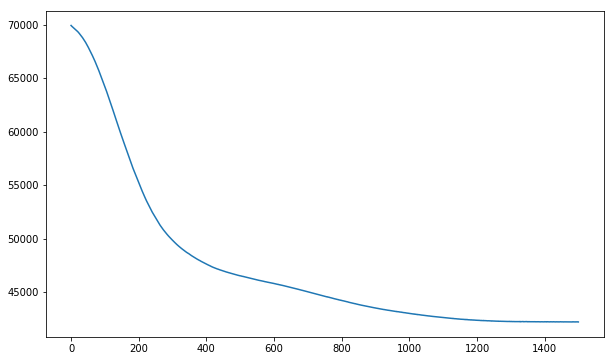

In [22]:
## plot the loss function
plt.plot(regr3.history.history['loss'])

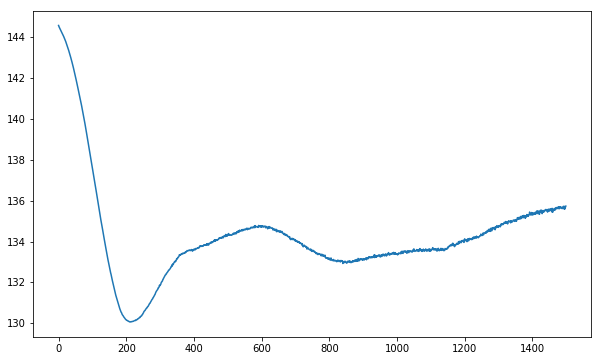

In [23]:
## plot the metrics
plt.plot(regr3.history.history['mean_absolute_error'])

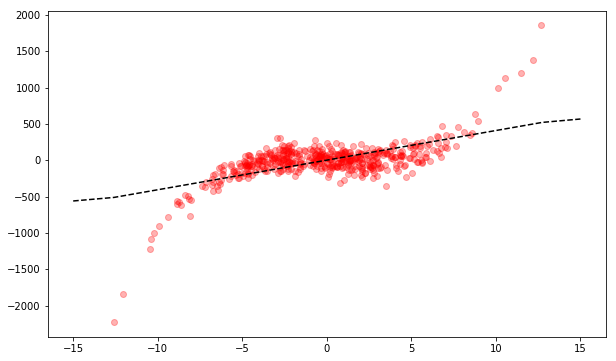

In [24]:
## original data
plt.plot(x2, y2,'ro',alpha=0.3)
## generate regular points along the range of x 
x2_range = np.linspace(-15,15,200)
## make predictions and plot
plt.plot(x2_range, 
         regr3.predict(trans_2.transform(x2_range.reshape(-1, 1))),
         'k--')

Perhaps we need to add more capacity to this model? One way to do so would be to make it 'deeper', by adding another hidden layer. Let's try that new architecture:

In [25]:
## build the model using a function since we would potentially call it multiple times
## add a single hidden dense layer with 64 units
def build_model3():
    model = models.Sequential()
    model.add(layers.Dense(64,
                           activation = 'relu',
                           input_dim=1))
    model.add(layers.Dense(64,
                           activation = 'relu'))
    model.add(layers.Dense(1,
                           activation = 'linear'))
    model.compile(optimizer ='RMSprop', 
                  loss = 'mse',
                  metrics = ['mae'])
    return model

In [26]:
## fit this model/architecture to my data
regr4 = build_model3()
regr4.fit(x2_scale,
         y2,
         epochs = 1500,
         batch_size = 64,
         verbose=0)

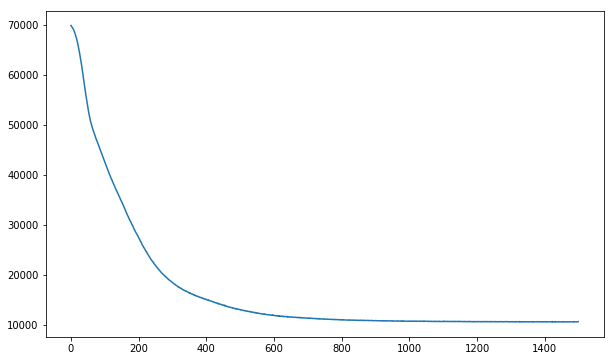

In [27]:
## plot the loss function
plt.plot(regr4.history.history['loss'])

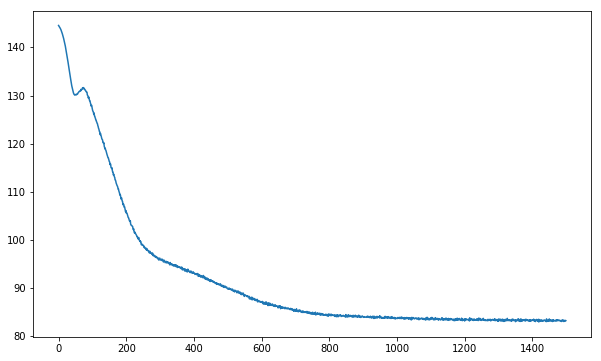

In [28]:
## plot the metrics
plt.plot(regr4.history.history['mean_absolute_error'])

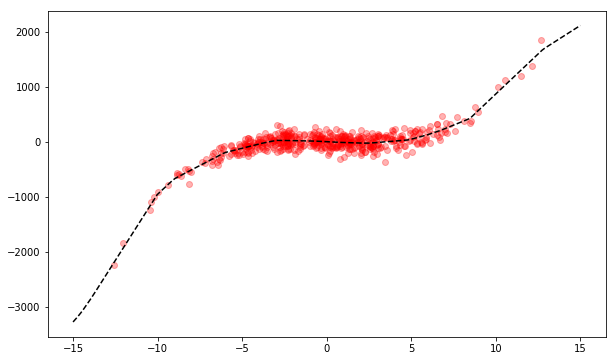

In [29]:
## original data
plt.plot(x2, y2,'ro',alpha=0.3)
## generate regular points along the range of x 
x2_range = np.linspace(-15,15,200)
## make predictions and plot
plt.plot(x2_range, 
         regr4.predict(trans_2.transform(x2_range.reshape(-1, 1))),
         'k--')

## Simulate a more complex function

Now let's try a harder non-linear function, a sin curve with some noise. 

In [30]:
## simulate non-linear model
np.random.seed(12)
n = 500
x3 = np.random.normal(loc=0,
                      scale=3,
                      size=n)
## simulate outcome
error_3 = \
    np.random.normal(loc=0,
                     scale=0.5,
                     size=n)
## map to outcome
y3 = 2 + 3*np.sin(x3) + error_3

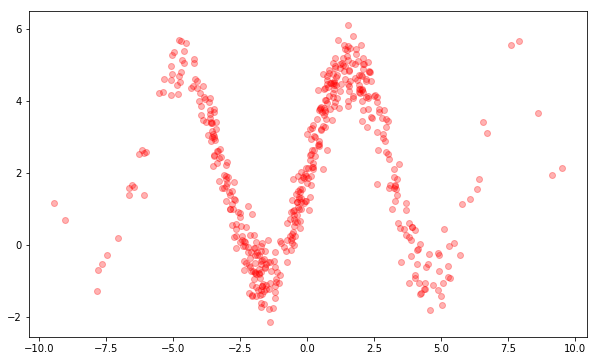

In [31]:
## plot relationship
## original data
plt.plot(x3, y3,'ro',alpha=0.3)

In [32]:
## scale data
trans_3 = preprocessing.StandardScaler().fit(x3.reshape(-1, 1))
x3_scale = trans_3.transform(x3.reshape(-1, 1)) ## reshape since sklearn wants a 2d object here

## fit the second architecture to my data 
regr5 = build_model2()
regr5.fit(x3_scale,
         y3,
         epochs = 1500,
         batch_size = 64,
         verbose=0)

In [33]:
regr5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


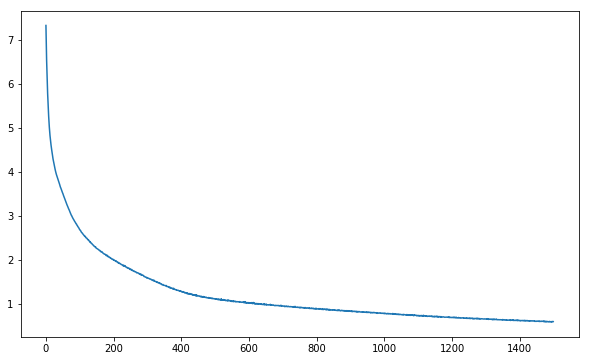

In [34]:
## plot the loss function
plt.plot(regr5.history.history['loss'])

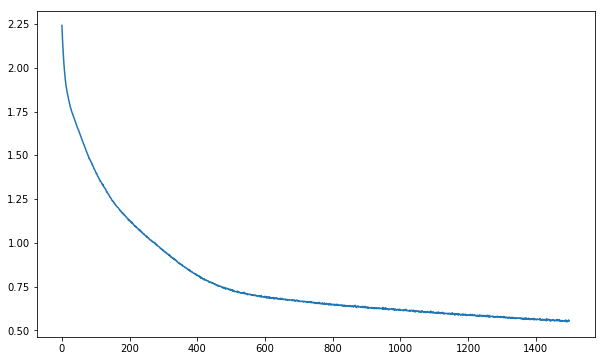

In [35]:
## plot the metrics
plt.plot(regr5.history.history['mean_absolute_error'])

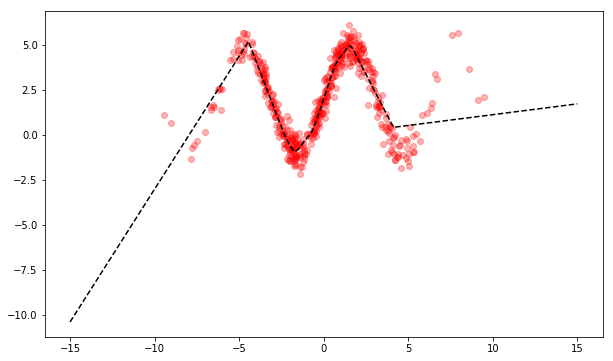

In [36]:
## original data
plt.plot(x3, y3,'ro',alpha=0.3)
## generate regular points along the range of x 
x3_range = np.linspace(-15,15,200)
## make predictions and plot
plt.plot(x3_range, 
         regr5.predict(trans_3.transform(x3_range.reshape(-1, 1))),
         'k--')

Perhaps we can do better if we run the model for more epochs? 

In [37]:
## scale data
trans_3 = preprocessing.StandardScaler().fit(x3.reshape(-1, 1))
x3_scale = trans_3.transform(x3.reshape(-1, 1)) ## reshape since sklearn wants a 2d object here

## fit the second architecture to my data 
regr6 = build_model3()
regr6.fit(x3_scale,
         y3,
         epochs = 1500,
         batch_size = 64,
         verbose=0)

In [38]:
regr6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


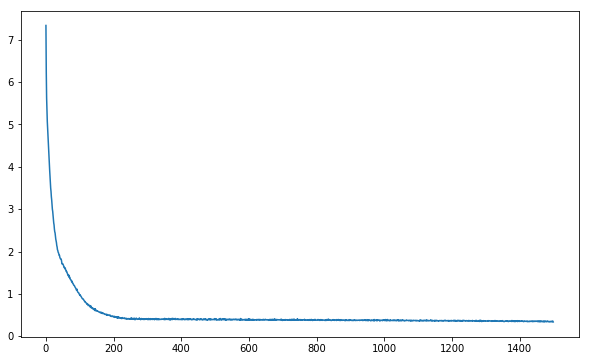

In [39]:
## plot the loss function
plt.plot(regr6.history.history['loss'])

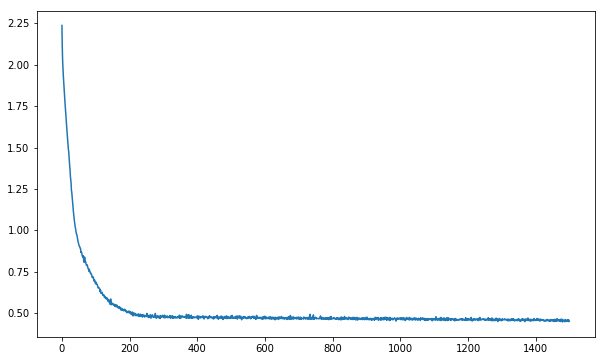

In [40]:
## plot the metrics
plt.plot(regr6.history.history['mean_absolute_error'])

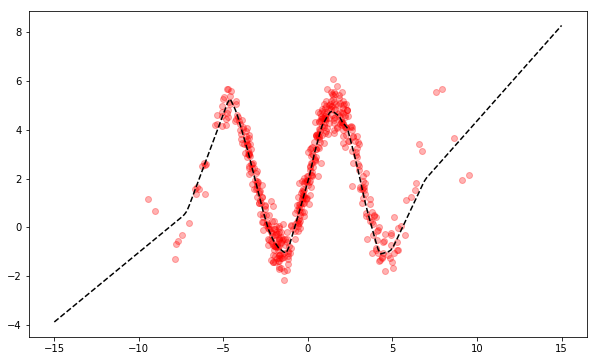

In [41]:
## original data
plt.plot(x3, y3,'ro',alpha=0.3)
## generate regular points along the range of x 
x3_range = np.linspace(-15,15,200)
## make predictions and plot
plt.plot(x3_range, 
         regr6.predict(trans_3.transform(x3_range.reshape(-1, 1))),
         'k--')

This does look a bit better now! We still are missing the tails of the data. But...we don't have much data out there, so perhaps it is unreasonable to get the fit perfectly. You could try running the model for longer periods of time, changing the optimizer, changing the loss function, or even changing the architecture of the model (deeper or wider) to improve the fit further. 